In [1]:
print(__doc__)
import math

import numpy as np
import numpy_indexed as npi
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import check_random_state
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression

pd.options.display.float_format = "{:.1f}".format

Automatically created module for IPython interactive environment


In [2]:
def retrieve_data_recid():
    
    attributes = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree']
    bias = 'race'
    target = 'two_year_recid'

    np.random.seed(42)

    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/Active-Learning-Performance-Benchmarking/main/RecidivismData_Normalized.csv", sep=',')
    data_col = data.columns
    df = data[(data[bias]==2)|(data[bias]==3)].copy().values

    kf = KFold(n_splits=4) #differ from original method
    for train_index, test_index in kf.split(df):
        train, test = df[train_index], df[test_index]
        # print("Size of X_train_full, X_test:", train.shape, test.shape)

    df_train = pd.DataFrame(data=train, columns=data_col)
    df_test = pd.DataFrame(data=test, columns=data_col)

    labeled = df_train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=5, random_state=42)) # ten sample in total labeled initially
    df_X_labeled = labeled[attributes]
    df_y_labeled = labeled[target]
    X_labeled = df_X_labeled.values
    y_labeled = df_y_labeled.values.astype('int64')
    b_labeled = labeled[bias].values-2
    (row_size, col_size) = X_labeled.shape

    unlabeled = df_train.drop(df_X_labeled.index)
    df_X_unlabeled = unlabeled[attributes]
    df_y_unlabeled = unlabeled[target]
    X_unlabeled = df_X_unlabeled.values
    y_unlabeled = df_y_unlabeled.values.astype('int64')
    b_unlabeled = unlabeled[bias].values-2

    X_test = df_test[attributes].values
    y_test = df_test[target].values
    y_test=y_test.astype('int')
    b_test = df_test[bias].values-2

    X_fair_est = X_unlabeled
    y_fair_est = y_unlabeled
    b_fair_est = b_unlabeled
    
    return (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est)

In [3]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass

class LogModel(BaseModel):

    def fit_predict(self, X_labeled, y_labeled, X_test, y_test):
        self.classifier = LogisticRegression(
            solver='liblinear'
            )
        self.classifier.fit(X_labeled, y_labeled)
        # self.y_test_predicted = self.classifier.predict(X_test)
        # self.y_unlabeled_predicted = self.classifier.predict(X_unlabeled)
        self.y_test_score = self.classifier.score(X_test, y_test)
        return (X_labeled, X_test, self.y_test_score)

In [4]:
def random_selection(probas_val, step):
    random_state = check_random_state(63)
    selection = np.random.choice(probas_val.shape[0], step, replace=False)
    return selection

In [5]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    def train(self, X_labeled, y_labeled, X_test, y_test):
        (X_labeled, X_test, self.y_test_score) = \
            self.model_object.fit_predict(X_labeled, y_labeled, X_test, y_test)
        return (X_labeled, X_test)

    def get_test_accuracy(self, i):
        classif_rate = self.y_test_score * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        # print("Accuracy rate is %f " % (classif_rate))

In [6]:
def normalizer(e_loss, f_loss):
    e_loss = np.reshape(e_loss, (1,len(e_loss)))
    f_loss = np.reshape(f_loss, (1,len(f_loss)))
    e_scaled = preprocessing.normalize(e_loss)
    # e_scaled=((e_loss-e_loss.min())/(e_loss.max()-e_loss.min()))
    f_scaled = preprocessing.normalize(f_loss)
    # f_scaled=((f_loss-f_loss.min())/(f_loss.max()-f_loss.min()))
    return (e_scaled, f_scaled)

In [7]:
def log_loss(probas_val):
    
    eps = np.finfo(probas_val.dtype).eps
    probas_val = np.clip(probas_val, eps, 1 - eps)
    e_loss = (-probas_val * np.log2(probas_val)).sum(axis=1)

    return e_loss

In [8]:
# separation \ Equal opportunity - Hardt, Price, Srebro (2016)

def stats_parity(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0p1=X_fair_est[(b_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0=X_fair_est[(b_fair_est==0)].shape[0]
    b1p1=X_fair_est[(b_fair_est==1)&(y_fair_pred==1)].shape[0]
    b1=X_fair_est[(b_fair_est==1)].shape[0]

    f_loss=(b0p1/b0)-(b1p1/b1)
    # print("Debug fair_loss shape:", b0p1, b0, b1p1, b1)
    
    return f_loss

def eqops(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y1p1=X_fair_est[(b_fair_est==0)&(y_fair_pred==1)&(y_fair_est==1)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p1=X_fair_est[(b_fair_est==1)&(y_fair_pred==1)&(y_fair_est==1)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    f_loss=(b0y1p1/b0y1)-(b1y1p1/b1y1)
    # print("Debug fair_loss shape:", b0p1, b0, b1p1, b1)
    
    return f_loss

def eqods(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y0p1=X_fair_est[(b_fair_est==0)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0y0=X_fair_est[(b_fair_est==0)&(y_fair_est==0)].shape[0]
    b1y0p1=X_fair_est[(b_fair_est==1)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b1y0=X_fair_est[(b_fair_est==1)&(y_fair_est==0)].shape[0]

    b0y1p1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)&(y_fair_pred==1)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)&(y_fair_pred==1)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    fpr_loss=abs((b0y0p1/b0y0)-(b1y0p1/b1y0))
    tpr_loss=abs((b0y1p1/b0y1)-(b1y1p1/b1y1))


    f_loss = (fpr_loss+tpr_loss)/2 # temporary solution
    
    return f_loss 

def disp_mist(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0y0p1=X_fair_est[(b_fair_est==0)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0y0=X_fair_est[(b_fair_est==0)&(y_fair_est==0)].shape[0]
    b1y0p1=X_fair_est[(b_fair_est==1)&(y_fair_est==0)&(y_fair_pred==1)].shape[0]
    b1y0=X_fair_est[(b_fair_est==1)&(y_fair_est==0)].shape[0]

    b0y1p0=X_fair_est[(b_fair_est==0)&(y_fair_est==1)&(y_fair_pred==0)].shape[0]
    b0y1=X_fair_est[(b_fair_est==0)&(y_fair_est==1)].shape[0]
    b1y1p0=X_fair_est[(b_fair_est==1)&(y_fair_est==1)&(y_fair_pred==0)].shape[0]
    b1y1=X_fair_est[(b_fair_est==1)&(y_fair_est==1)].shape[0]

    fpr_loss=abs((b0y0p1/b0y0)-(b1y0p1/b1y0))
    fnr_loss=abs((b0y1p0/b0y1)-(b1y1p0/b1y1))


    f_loss = (fpr_loss+fnr_loss)/2 # temporary solution
    
    return f_loss 

def disp_impt(X_fair_est, y_fair_est, b_fair_est, classifier):
    
    y_fair_pred = classifier.predict(X_fair_est)

    b0p1=X_fair_est[(b_fair_est==0)&(y_fair_pred==1)].shape[0]
    b0=X_fair_est[(b_fair_est==0)].shape[0]
    b1p1=X_fair_est[(b_fair_est==1)&(y_fair_pred==1)].shape[0]
    b1=X_fair_est[(b_fair_est==1)].shape[0]

    f_loss=(b0p1/b0)/(b1p1/b1)
    # print("Debug fair_loss shape:", b0p1, b0, b1p1, b1)
    f_loss = f_loss-1
    return f_loss
    

In [9]:
# selecting fairness criteria

def fair_measure(X_fair_est, y_fair_est, b_fair_est, classifier=None, criteria=0):

    if criteria == 'equal_opportunity':
        return eqops(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'statistical_parity':
        return stats_parity(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'disparate_mistreatment':
        return disp_mist(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == 'equalized_odds':
        return eqods(X_fair_est, y_fair_est, b_fair_est, classifier)
    elif criteria == "disparate_impact":
        return disp_impt(X_fair_est, y_fair_est, b_fair_est, classifier)

In [10]:
def unfairness_reduction_sampling(query_size, X_unlabeled, X_labeled, y_labeled, classifier, X_fair_est, y_fair_est, b_fair_est, probas_val, step, criteria):
    # further to be defined, now assume only fairness loss
    # query size used here
    div = 0

    unlabeled_size = len(X_unlabeled)
    f_loss = np.zeros(unlabeled_size)
    for i in range(unlabeled_size):
        f_loss_temp = []
        for j in range(2):
            X_labeled_temp = np.append(X_labeled, [X_unlabeled[i]], axis = 0)
            y_labeled_temp = np.append(y_labeled, [j], axis = 0)
            classifier_temp = LogisticRegression(solver='liblinear').fit(X_labeled_temp, y_labeled_temp)
            f_loss_temp = np.append(f_loss_temp, fair_measure(X_fair_est, y_fair_est, b_fair_est, classifier=classifier_temp, criteria=criteria))
            f_loss_temp[np.isnan(f_loss_temp)] = 0
            
        proba_0 = classifier.predict_proba(X_unlabeled)[i][0]
        proba_1 = 1 - proba_0
        f_loss[i] = (f_loss_temp).dot([proba_0, proba_1])

    e_loss = log_loss(probas_val)

    e_scaled, f_scaled = normalizer(e_loss, f_loss)
    f_scaled[np.isnan(f_scaled)] = 0

    loss = div*(e_loss)+(1-div)*f_loss
    
    selection = np.argsort(loss)[::-1][:step]

    return selection

In [11]:
def pre_filter(X_data, b_data, y_data, budget): 

    temp_columns = ['MarriageStatus','age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count', 'days_b_screening_arrest','c_days_from_compas','c_charge_degree','race','two_year_recid']
    np.random.seed(84)

    # print("Debug data:", X_data.shape, b_data.shape, y_data.shape)
    temp_data = np.c_[X_data, b_data, y_data]
    temp_df = pd.DataFrame(data=temp_data, columns=temp_columns)
    candidates_data = temp_df.groupby('race', group_keys=False).apply(lambda x: x.sample(n=math.ceil(budget/2), random_state = 84))
    # print("Debug ceil:", math.ceil(budget/2))
    # print("Debug cand:", candidates)
    candidates_index = candidates_data.index.values
    # print("Debug index:", candidates_index.shape, candidates_index)

    return candidates_index

In [12]:
def metrics(X_test, y_test, b_test, classifier):
    y_test_pred = classifier.predict(X_test)
    print("Classification report for classifier %s:\n%s\n" % (classifier, classification_report(y_test, y_test_pred)))
    print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_test_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp) 
    fpr = fp/(fp+tn)
    fnr = fn/(tp+fn)
    fdr = fp/(tp+fp)

    fig, ax = plt.subplots()

    model_displays = {}
    for i in np.unique(y_test):
        model_displays[i] = plot_roc_curve(
            classifier, X_test[b_test==i], y_test[b_test==i], ax=ax, name=i)
    ax.set_title('ROC curve')
    plt.show()
    
    # plot_roc_curve(classifier, X_test, y_test)
    
    # plot_roc_curve(classifier, X_test[b_test==0], y_test[b_test==0])
    # plot_roc_curve(classifier, X_test[b_test==1], y_test[b_test==1])
    # plt.axline([0, 0], [1, 1])
    # plt.show()  

In [13]:
def scatters(X_unlabeled, b_unlabeled, probas_val, uncertain_samples):
    y_plot = probas_val
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(X_unlabeled[:,1], y_plot[:,1], c=b_unlabeled, cmap = 'Pastel1')
    ax.scatter(X_unlabeled[:,1][uncertain_samples], y_plot[:,1][uncertain_samples], c=b_unlabeled[uncertain_samples], edgecolors='black', s=100, cmap = 'Pastel1')
    ax.set_xlabel('Age')
    ax.set_ylabel('Score')
    ax.set_title('Population plot')
    y_plot = np.delete(y_plot, uncertain_samples, axis=0)

In [14]:
class active_learning(object):

    def __init__(self, step, budget, model_object, criteria):
        self.step = step
        self.budget = budget
        self.model_object = model_object
        # self.sample_selection_function = selection_function
        self.criteria = criteria
        
    def run(self, X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, sub_option):
  
        self.clf_model = TrainModel(self.model_object)
        (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
        active_iteration = 1
        self.clf_model.get_test_accuracy(active_iteration)

        self.query_size = len(X_labeled)
        fairness = []
        fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))
        metrics(X_test, y_test, b_test, self.clf_model.model_object.classifier)

        while self.query_size <= self.budget-self.step:

            active_iteration += 1
            self.query_size += self.step

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_unlabeled)
            
            # print("Debug predicted:", y_unlabeled_predicted.shape)
            # print("Debug probas_val:", probas_val.shape)

            if sub_option == "Pre_filter":

                candidates_index = pre_filter(X_unlabeled, b_unlabeled, y_unlabeled, self.budget)
                uncertain_samples = unfairness_reduction_sampling(self.query_size, X_unlabeled[candidates_index], X_labeled, y_labeled, self.clf_model.model_object.classifier, X_fair_est, y_fair_est, b_fair_est, probas_val[candidates_index], self.step, self.criteria)

            elif sub_option == "No_filter": 

                uncertain_samples = unfairness_reduction_sampling(self.query_size, X_unlabeled, X_labeled, y_labeled, self.clf_model.model_object.classifier, X_fair_est, y_fair_est, b_fair_est, probas_val, self.step, self.criteria)

            elif sub_option == "Filter_only":

                uncertain_samples = random_selection(probas_val, self.step)
            # print("Debug shape of X_unlabeled and loss:", selection)

            scatters(X_unlabeled, b_unlabeled, probas_val, uncertain_samples)

            X_labeled = np.concatenate((X_labeled, X_unlabeled[uncertain_samples]))
            y_labeled = np.concatenate((y_labeled, y_unlabeled[uncertain_samples]))
            X_unlabeled = np.delete(X_unlabeled, uncertain_samples, axis=0)
            y_unlabeled = np.delete(y_unlabeled, uncertain_samples, axis=0)
            b_unlabeled = np.delete(b_unlabeled, uncertain_samples, axis=0)
            
            (X_labeled, X_test) = self.clf_model.train(X_labeled, y_labeled, X_test, y_test)
            fairness = np.append(fairness, fair_measure(X_test, y_test, b_test, classifier=self.clf_model.model_object.classifier, criteria=self.criteria))
            self.clf_model.get_test_accuracy(active_iteration)

            metrics(X_test, y_test, b_test, self.clf_model.model_object.classifier)

        return self.clf_model.accuracies, fairness

In [15]:
def non_active_learning(init_index, X_unlabeled, y_unlabeled, X_labeled,y_labeled, X_test, y_test, b_test, budget, step, unfairness_criteria): 

    initial_X_train = X_labeled
    initial_y_train = y_labeled
    nonal_X_train = X_unlabeled
    nonal_y_train = y_unlabeled
    nonal_X_test = X_test
    nonal_y_test = y_test
    nonal_b_test = b_test
    nonal_fairness = []

    nonal_accuracies=[]

    classifier_nonal = LogisticRegression(
            solver='liblinear'
            )

    classifier_nonal.fit(initial_X_train, initial_y_train)
    initial_y_pred = classifier_nonal.predict(nonal_X_test)
    nonal_fairness = np.append(nonal_fairness, fair_measure(nonal_X_test, nonal_y_test, nonal_b_test, classifier=classifier_nonal, criteria=unfairness_criteria))
    nonal_accuracies.append(accuracy_score(nonal_y_test, initial_y_pred)*100)

    for i in np.arange(init_index+step,budget+1,step):
        classifier_nonal.fit(nonal_X_train[:i], nonal_y_train[:i])
        nonal_y_pred = classifier_nonal.predict(nonal_X_test)
        nonal_fairness = np.append(nonal_fairness, fair_measure(nonal_X_test, nonal_y_test, nonal_b_test, classifier=classifier_nonal, criteria=unfairness_criteria))
        nonal_accuracies.append(accuracy_score(nonal_y_test, nonal_y_pred)*100)

    return nonal_accuracies, nonal_fairness

In [16]:
def experiment(model,budget,step,criteria,sub_option=None):
    
    (X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est) = retrieve_data_recid()
    init_index = len(X_labeled)
        
    act_alg = active_learning(step, budget, model, criteria)

    ur_accuracies, ur_fairness = act_alg.run(X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, sub_option)

    rs_accuracies, rs_fairness = act_alg.run(X_labeled, y_labeled, b_labeled, row_size, col_size, X_unlabeled, y_unlabeled, b_unlabeled, X_test, y_test, b_test, X_fair_est, y_fair_est, b_fair_est, "Filter_only")

    nonal_accuracies, nonal_fairness = non_active_learning(init_index, X_unlabeled, y_unlabeled, X_labeled, y_labeled, X_test, y_test, b_test, budget, step, criteria)

    print("unfairness-based accuracies",ur_accuracies)
    print("random-based accuracies",rs_accuracies)
    print("non-active accuracies",nonal_accuracies)
    print("unfairness-based fairness",ur_fairness)
    print("random-based fairness",rs_fairness)
    print("non-active fairness",nonal_fairness)
    
    x_axis = np.arange(init_index,budget+1,step)
    fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
    fig.suptitle('Fairness and accuracy metrics')
    ax1.plot(x_axis, ur_fairness, color='r', label='unfair-active')
    ax1.plot(x_axis, rs_fairness, color='g', label='random-active')
    ax1.plot(x_axis, nonal_fairness, color='b', label='non-active')
    ax1.legend()
    ax2.plot(x_axis, ur_accuracies, color='r', label='unfair-active')
    ax2.plot(x_axis, rs_accuracies, color='g', label='random-active')
    ax2.plot(x_axis, nonal_accuracies, color='b', label='non-active')
    ax2.legend()
    ax1.set_xlabel('Sample size')
    ax1.set_ylabel('Unfairness')
    ax2.set_ylabel('Accuracies')

    plt.show()

--------------------------------
Iteration: 1
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       774
           1       0.57      0.45      0.50       694

    accuracy                           0.58      1468
   macro avg       0.57      0.57      0.57      1468
weighted avg       0.57      0.58      0.57      1468


Confusion matrix:
[[535 239]
 [383 311]]


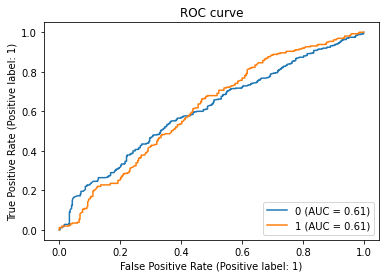

--------------------------------
Iteration: 2
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       774
           1       0.57      0.57      0.57       694

    accuracy                           0.59      1468
   macro avg       0.59      0.59      0.59      1468
weighted avg       0.59      0.59      0.59      1468


Confusion matrix:
[[471 303]
 [299 395]]


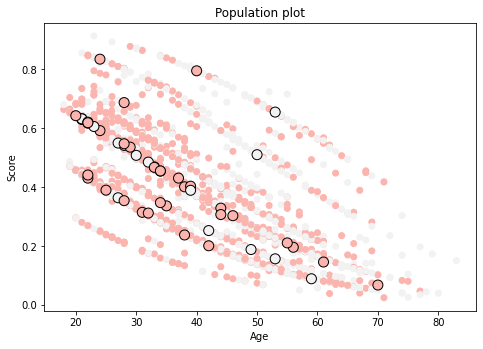

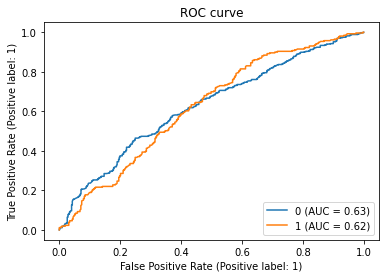

--------------------------------
Iteration: 3
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       774
           1       0.56      0.65      0.60       694

    accuracy                           0.59      1468
   macro avg       0.60      0.60      0.59      1468
weighted avg       0.60      0.59      0.59      1468


Confusion matrix:
[[417 357]
 [240 454]]


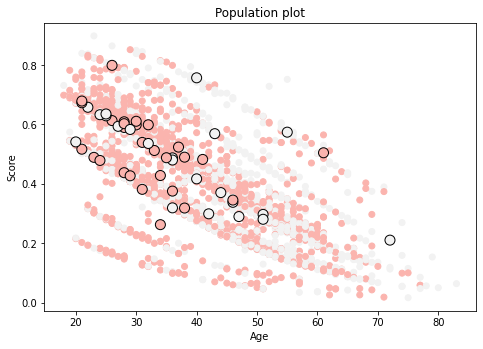

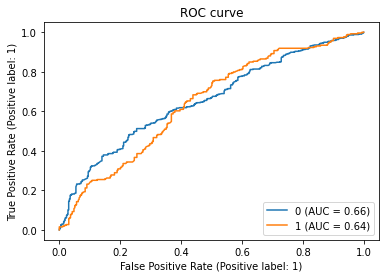

--------------------------------
Iteration: 4
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       774
           1       0.57      0.66      0.62       694

    accuracy                           0.61      1468
   macro avg       0.61      0.61      0.61      1468
weighted avg       0.61      0.61      0.61      1468


Confusion matrix:
[[434 340]
 [234 460]]


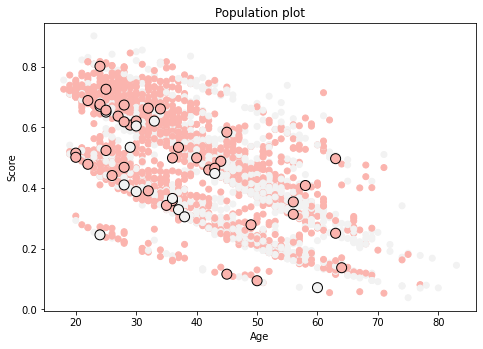

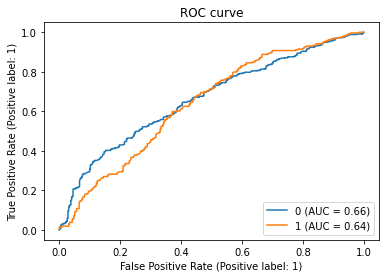

--------------------------------
Iteration: 5
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       774
           1       0.59      0.70      0.64       694

    accuracy                           0.63      1468
   macro avg       0.63      0.63      0.63      1468
weighted avg       0.64      0.63      0.63      1468


Confusion matrix:
[[438 336]
 [209 485]]


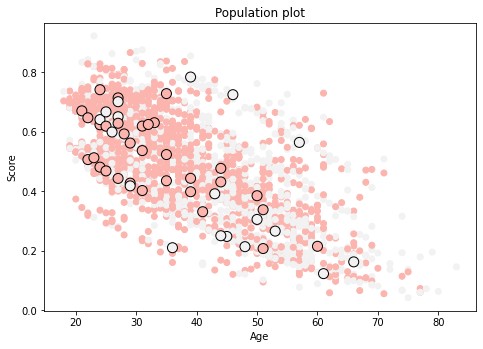

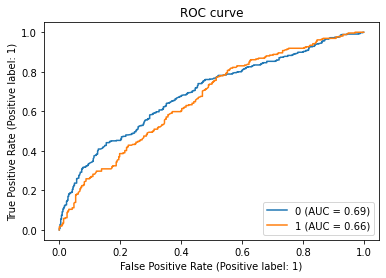

--------------------------------
Iteration: 6
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       774
           1       0.60      0.62      0.61       694

    accuracy                           0.63      1468
   macro avg       0.63      0.63      0.63      1468
weighted avg       0.63      0.63      0.63      1468


Confusion matrix:
[[493 281]
 [264 430]]


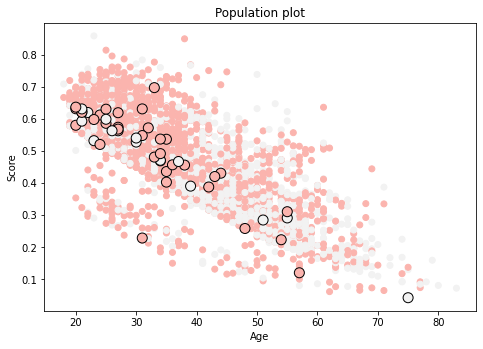

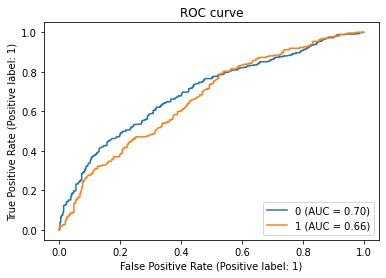

--------------------------------
Iteration: 7
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.64      0.69      0.66       774
           1       0.62      0.57      0.59       694

    accuracy                           0.63      1468
   macro avg       0.63      0.63      0.63      1468
weighted avg       0.63      0.63      0.63      1468


Confusion matrix:
[[534 240]
 [299 395]]


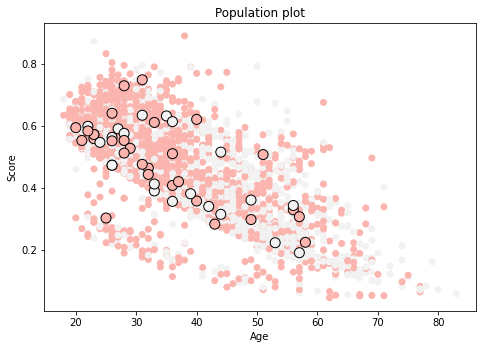

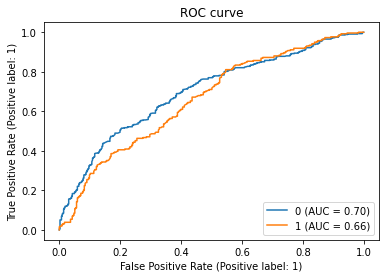

--------------------------------
Iteration: 8
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       774
           1       0.63      0.58      0.60       694

    accuracy                           0.64      1468
   macro avg       0.64      0.64      0.64      1468
weighted avg       0.64      0.64      0.64      1468


Confusion matrix:
[[532 242]
 [289 405]]


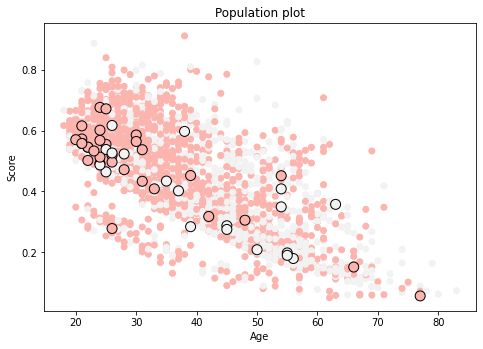

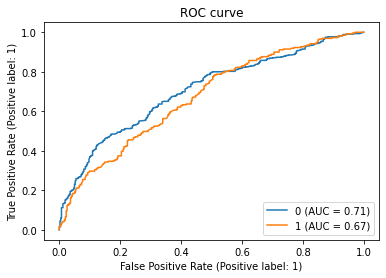

--------------------------------
Iteration: 9
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       774
           1       0.65      0.55      0.60       694

    accuracy                           0.65      1468
   macro avg       0.65      0.64      0.64      1468
weighted avg       0.65      0.65      0.64      1468


Confusion matrix:
[[568 206]
 [312 382]]


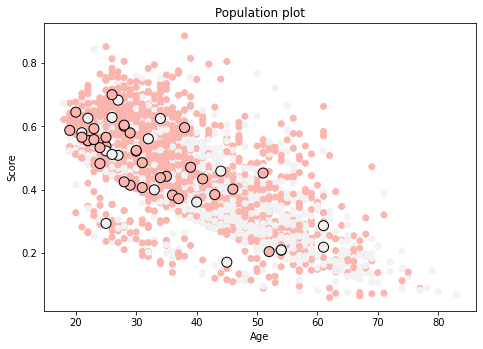

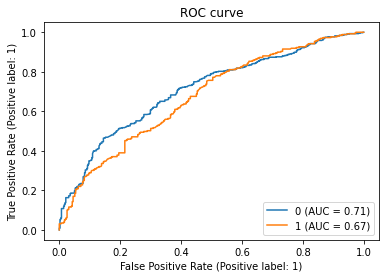

--------------------------------
Iteration: 10
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       774
           1       0.65      0.56      0.60       694

    accuracy                           0.65      1468
   macro avg       0.65      0.65      0.65      1468
weighted avg       0.65      0.65      0.65      1468


Confusion matrix:
[[569 205]
 [305 389]]


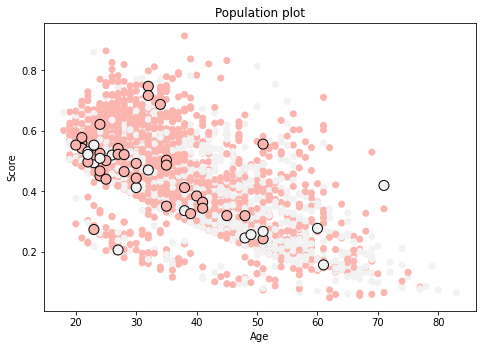

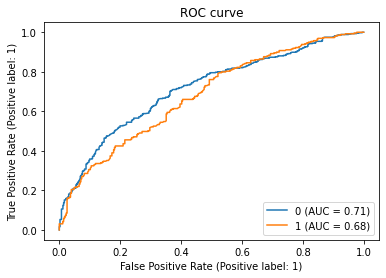

--------------------------------
Iteration: 1
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       774
           1       0.57      0.45      0.50       694

    accuracy                           0.58      1468
   macro avg       0.57      0.57      0.57      1468
weighted avg       0.57      0.58      0.57      1468


Confusion matrix:
[[535 239]
 [383 311]]


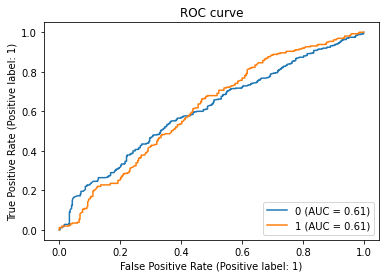

--------------------------------
Iteration: 2
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       774
           1       0.62      0.53      0.57       694

    accuracy                           0.63      1468
   macro avg       0.63      0.62      0.62      1468
weighted avg       0.63      0.63      0.62      1468


Confusion matrix:
[[550 224]
 [325 369]]


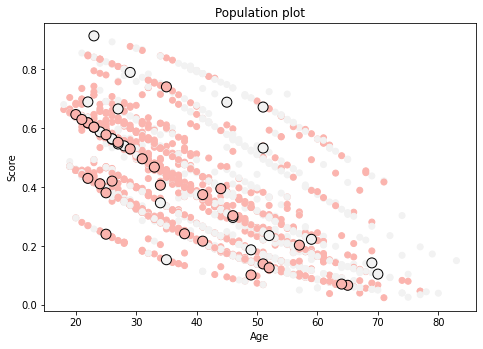

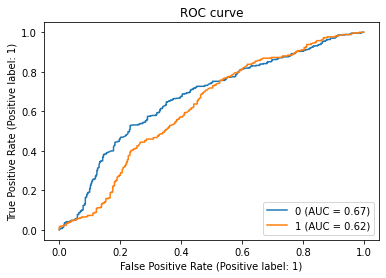

--------------------------------
Iteration: 3
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       774
           1       0.63      0.50      0.56       694

    accuracy                           0.62      1468
   macro avg       0.63      0.62      0.62      1468
weighted avg       0.63      0.62      0.62      1468


Confusion matrix:
[[569 205]
 [346 348]]


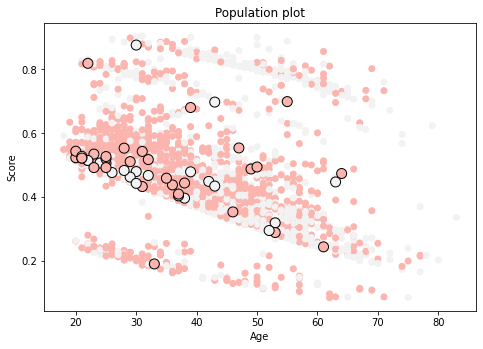

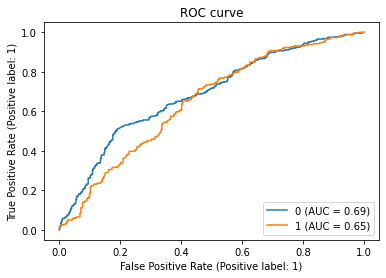

--------------------------------
Iteration: 4
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.57      0.84      0.68       774
           1       0.63      0.31      0.41       694

    accuracy                           0.59      1468
   macro avg       0.60      0.57      0.55      1468
weighted avg       0.60      0.59      0.56      1468


Confusion matrix:
[[650 124]
 [481 213]]


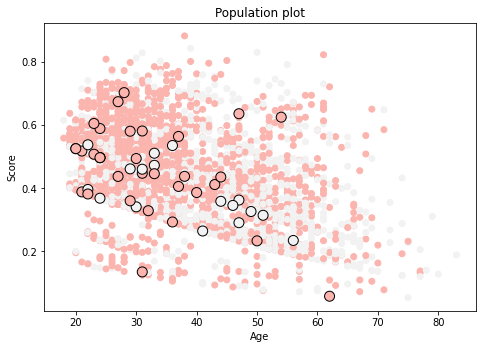

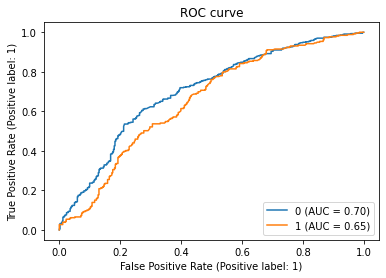

--------------------------------
Iteration: 5
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.61      0.83      0.71       774
           1       0.69      0.42      0.52       694

    accuracy                           0.63      1468
   macro avg       0.65      0.62      0.61      1468
weighted avg       0.65      0.63      0.62      1468


Confusion matrix:
[[642 132]
 [404 290]]


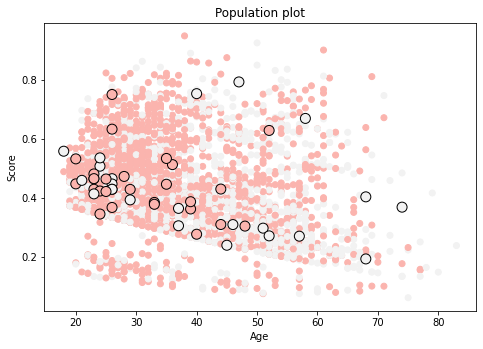

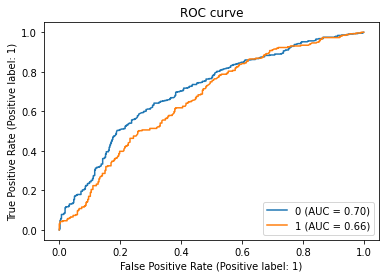

--------------------------------
Iteration: 6
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       774
           1       0.66      0.56      0.61       694

    accuracy                           0.66      1468
   macro avg       0.66      0.65      0.65      1468
weighted avg       0.66      0.66      0.65      1468


Confusion matrix:
[[578 196]
 [308 386]]


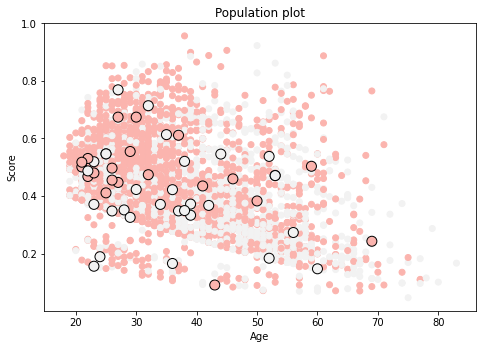

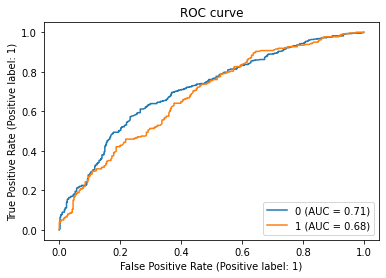

--------------------------------
Iteration: 7
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       774
           1       0.64      0.59      0.61       694

    accuracy                           0.65      1468
   macro avg       0.65      0.64      0.64      1468
weighted avg       0.65      0.65      0.65      1468


Confusion matrix:
[[538 236]
 [282 412]]


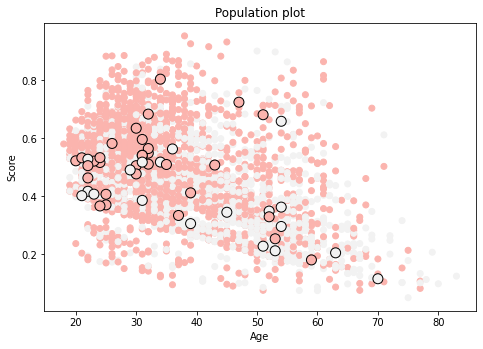

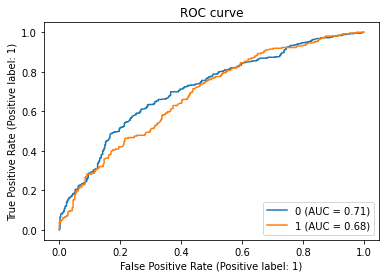

--------------------------------
Iteration: 8
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       774
           1       0.64      0.60      0.62       694

    accuracy                           0.65      1468
   macro avg       0.65      0.65      0.65      1468
weighted avg       0.65      0.65      0.65      1468


Confusion matrix:
[[542 232]
 [280 414]]


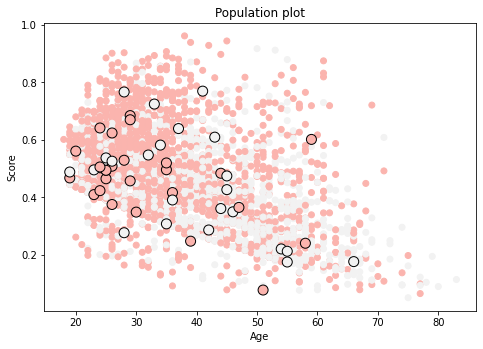

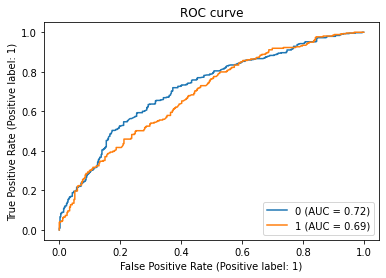

--------------------------------
Iteration: 9
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       774
           1       0.64      0.62      0.63       694

    accuracy                           0.65      1468
   macro avg       0.65      0.65      0.65      1468
weighted avg       0.65      0.65      0.65      1468


Confusion matrix:
[[532 242]
 [267 427]]


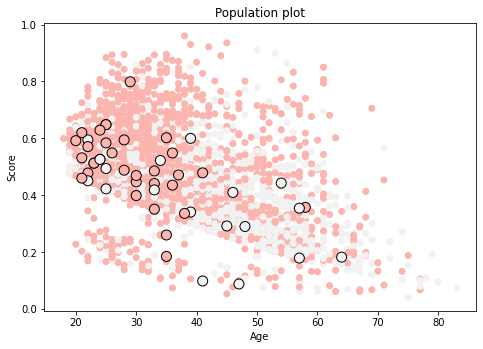

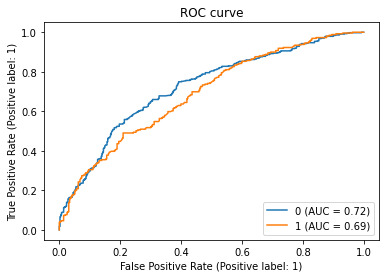

--------------------------------
Iteration: 10
Classification report for classifier LogisticRegression(solver='liblinear'):
              precision    recall  f1-score   support

           0       0.66      0.73      0.70       774
           1       0.66      0.59      0.62       694

    accuracy                           0.66      1468
   macro avg       0.66      0.66      0.66      1468
weighted avg       0.66      0.66      0.66      1468


Confusion matrix:
[[566 208]
 [286 408]]


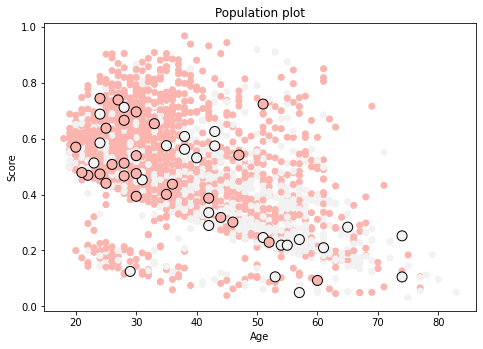

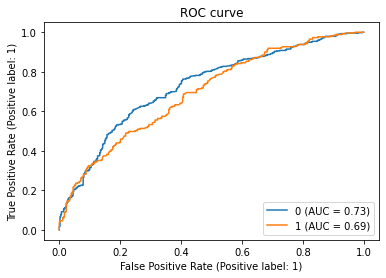

unfairness-based accuracies [57.629427792915536, 58.991825613079016, 59.33242506811989, 60.89918256130791, 62.874659400544964, 62.874659400544964, 63.28337874659401, 63.828337874659404, 64.71389645776566, 65.25885558583107]
random-based accuracies [57.629427792915536, 62.60217983651226, 62.46594005449592, 58.787465940054496, 63.48773841961853, 65.66757493188011, 64.71389645776566, 65.12261580381471, 65.32697547683924, 66.34877384196184]
non-active accuracies [57.629427792915536, 56.47138964577657, 60.42234332425068, 61.71662125340599, 63.555858310626704, 64.50953678474114, 64.85013623978202, 64.50953678474114, 65.53133514986375, 65.39509536784742]
unfairness-based fairness [0.06723461 0.07969197 0.07805384 0.08441647 0.12758175 0.1416187
 0.11687168 0.14020585 0.12026639 0.12925295]
random-based fairness [0.06723461 0.05804378 0.11838495 0.0460723  0.10308848 0.15277565
 0.14585825 0.15690275 0.16311397 0.1707553 ]
non-active fairness [0.06723461 0.05301581 0.07079537 0.16362704 0.1727

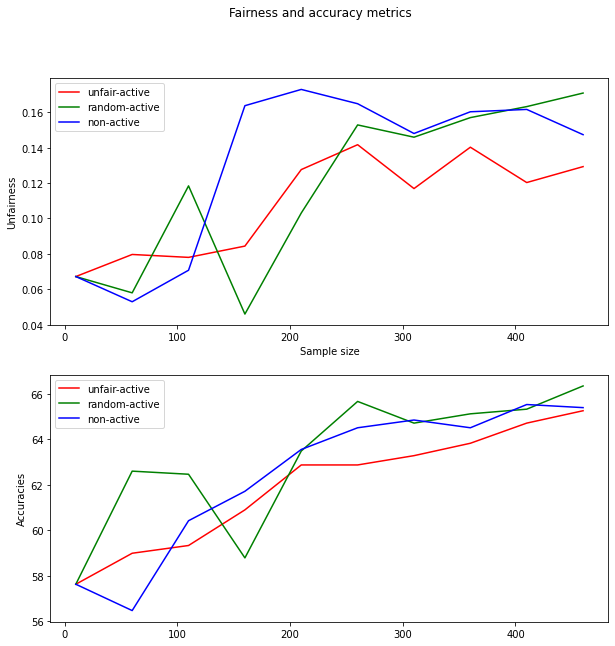

In [17]:
experiment(LogModel,500,50,"equalized_odds","Pre_filter")